In [1]:
import os
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm
from tensorflow import keras

# Model

In [2]:
IMG_HEIGHT=512
IMG_WIDTH=512
IMG_CHANNELS=3

In [3]:
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = keras.layers.Dropout(0.15)(c1)
c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = keras.layers.MaxPooling2D((2, 2))(c1)

c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = keras.layers.Dropout(0.15)(c2)
c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = keras.layers.MaxPooling2D((2, 2))(c2)

c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = keras.layers.Dropout(0.15)(c3)
c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = keras.layers.MaxPooling2D((2, 2))(c3)

c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = keras.layers.Dropout(0.15)(c4)
c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = keras.layers.MaxPooling2D((2, 2))(c4)

c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = keras.layers.Dropout(0.15)(c5)
c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = keras.layers.Dropout(0.2)(c6)
c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = keras.layers.Dropout(0.2)(c7)
c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = keras.layers.Dropout(0.15)(c8)
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = keras.layers.Dropout(0.15)(c9)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 32  8224       ['conv2d_13[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7

In [4]:
input_train = "./train/input"
output_train = "./train/output"
input_test = "./test/input"

TRAIN_INPUT = "./train/input"
TRAIN_OUTPUT = "./train/output"
TEST_OUTPUT = "./test/input"

X_train_path = sorted(
    [
        os.path.join(input_train, fname)
        for fname in os.listdir(TRAIN_INPUT)
        if fname.endswith(".png")
    ]
)
for c in X_train_path[:10]:
    print(c)
Y_train_path = sorted(
    [
        os.path.join(output_train, fname)
        for fname in os.listdir(TRAIN_OUTPUT)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
for c in Y_train_path[:10]:
    print(c)
X_test_path = sorted(
    [
        os.path.join(input_test, fname)
        for fname in os.listdir(TEST_OUTPUT)
        if fname.endswith(".png")
    ]
)

./train/input\0_0.png
./train/input\0_1024.png
./train/input\0_10240.png
./train/input\0_10468.png
./train/input\0_1536.png
./train/input\0_2048.png
./train/input\0_2560.png
./train/input\0_3072.png
./train/input\0_3584.png
./train/input\0_4096.png
./train/output\0_0.png
./train/output\0_1024.png
./train/output\0_10240.png
./train/output\0_10468.png
./train/output\0_1536.png
./train/output\0_2048.png
./train/output\0_2560.png
./train/output\0_3072.png
./train/output\0_3584.png
./train/output\0_4096.png


In [5]:
IMG_HEIGHT=512
IMG_WIDTH=512
IMG_CHANNELS=3
X_train = np.zeros((len(X_train_path), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(X_train_path), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(X_test_path), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, image in tqdm(enumerate(X_train_path), total=len(X_train_path)):
    img = imread(image)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, image in tqdm(enumerate(Y_train_path), total=len(Y_train_path)):
    img = imread(image)   
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
#     img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True), axis=-1)
    Y_train[n] = img


for n, image in tqdm(enumerate(X_test_path), total=len(X_test_path)):
    img = imread(image)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

C:\Users\Admin\AppData\Local\Temp\ipykernel_16984\186260973.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(X_train_path), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:06<00:00, 13.41it/s]


In [6]:
checkpointer = keras.callbacks.ModelCheckpoint('model_for_plants.h5', verbose=1, save_best_only=True);
callbacks = [
    keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs')]

result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, callbacks=callbacks)

idx = random.randint(0, len(X_train))

Epoch 1/10
22/22 [==============================] - 25s 636ms/step - loss: 0.0606 - accuracy: 0.9930 - val_loss: 0.0241 - val_accuracy: 0.9977
Epoch 2/10
22/22 [==============================] - 12s 568ms/step - loss: 0.0182 - accuracy: 0.9979 - val_loss: 0.0259 - val_accuracy: 0.9977


In [7]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 5s 1s/step


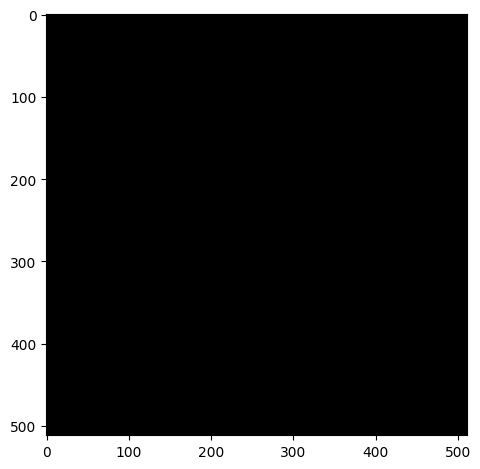

In [14]:
imshow(np.squeeze(preds_test_t[0]*0.9))
plt.show()
